## 1- Frame the Problem:

	How are the smart meters spreading?

	What is the trend of solar panel installation , ie homes -produced energy

	Other insights into trends for different network adminstrators

	What is the energy consumption the next year?


## 2- Get the Data

In [1]:
# Import Libraries
import os,shutil
import pandas as pd
import zipfile
from tabulate import tabulate
from os import rename
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import glob
import matplotlib.cm as cm
import itertools
%matplotlib inline
import seaborn as sns
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn import svm, preprocessing
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Unzip downloaded dataset
def unzip_data():
    """
    Load downloaded data and unzip in newly created directory
    """
    zip_path = os.getcwd()+"/dutch-energy.zip"
    # create folder called energy where files will be unziped
    extract_file = os.path.join("datasets", "energy")
    print(extract_file)
    # check if path directory already exist
    if os.path.exists(extract_file):
        shutil.rmtree('./datasets')
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_file)

unzip_data()

datasets/energy


In [3]:
# Explore extracted list of files
extract_file = os.path.join("datasets", "energy")
files_av = []
for root, dirs, files in os.walk(extract_file):
    print("Extracted folders.{}".format(dirs))
    # check csv files that have been extracted in their folders
    for name in files:
        if name.endswith(".csv"):
            files_av.append(name)
          
print("Extracted folders.{}".format(dirs))
files_av

Extracted folders.['Gas', 'Electricity']
Extracted folders.[]
Extracted folders.[]
Extracted folders.[]


['stedin_gas_2018.csv',
 'stedin_gas_2019.csv',
 'stedin_gas_2009.csv',
 'liander_gas_01012019.csv',
 'liander_gas_01012018.csv',
 'enexis_gas_01012019.csv',
 'enexis_gas_01012018.csv',
 'liander_gas_01012009.csv',
 'liander_gas_01012010.csv',
 'enexis_gas_01012015.csv',
 'enexis_gas_01012014.csv',
 'liander_gas_01012011.csv',
 'liander_gas_01012013.csv',
 'enexis_gas_01012016.csv',
 'enexis_gas_01012017.csv',
 'liander_gas_01012012.csv',
 'liander_gas_01012016.csv',
 'enexis_gas_01012013.csv',
 'enexis_gas_01012012.csv',
 'liander_gas_01012017.csv',
 'liander_gas_01012015.csv',
 'enexis_gas_01012010.csv',
 'enexis_gas_01012011.csv',
 'liander_gas_01012014.csv',
 'stedin_gas_2012.csv',
 'stedin_gas_2013.csv',
 'stedin_gas_2011.csv',
 'stedin_gas_2010.csv',
 'stedin_gas_2014.csv',
 'stedin_gas_2015.csv',
 'stedin_gas_2017.csv',
 'stedin_gas_2016.csv',
 'stedin_electricity_2019.csv',
 'stedin_electricity_2018.csv',
 'stedin_electricity_2009.csv',
 'liander_electricity_01012019.csv',
 'en

### Issues to address:

1- Files names to be standarized as follow: Network adminstrator + gas or electricity + year(20xx)

2- Each adminstrator datasets for gas and electricity to be combined into 1 dataframe for all years. Thsi will results in 6 data sets as follow:
    
    GAS:
    * enexis_gas
    * liander_gas
    * stedin_gas
    Eletricity:
    * enexis_electricity
    * liander_electricity
    * steding_electricity

In [4]:
# create function to standarise file name as follow: Network_admin+energy_type+year
def rename_files(extract_file):
    """
    fuction to rename csv files as follow Network_admin+energy_type+year
    """
    # looping through the 2 energy folders
    for folder in ['Electricity','Gas'] :  
         # looping through the  directories in the folders Electricity & Gas
        for file in os.listdir(extract_file +"/" +folder):
            # extract network admin name
            network_admin=file.split("_")[0]
            #extract the year
            year = file.split("_")[2]
            # compose the new name
            new_name = network_admin+"_"+folder+"_"+ year[-8:]
            os.rename(extract_file +"/"+ folder+"/" +file, extract_file +"/"+folder+"/"+new_name)
            # pepare list of csv files name for visual review to ensure names are correct
            story = '\n'.join(os.listdir('./datasets/energy'+"/"+folder))
            print("** List of files in {} are: '\n'{}".format(folder,story))
                  
                  
rename_files(extract_file)

** List of files in Electricity are: '
'stedin_Electricity_2019.csv
stedin_electricity_2018.csv
stedin_electricity_2009.csv
liander_electricity_01012019.csv
enexis_electricity_01012016.csv
enexis_electricity_01012017.csv
liander_electricity_01012018.csv
enexis_electricity_01012015.csv
enexis_electricity_01012014.csv
enexis_electricity_01012010.csv
enexis_electricity_01012011.csv
enexis_electricity_01012013.csv
enexis_electricity_01012012.csv
liander_electricity_01012009.csv
liander_electricity_01012010.csv
liander_electricity_01012011.csv
liander_electricity_01012013.csv
liander_electricity_01012012.csv
liander_electricity_01012016.csv
enexis_electricity_01012019.csv
enexis_electricity_01012018.csv
liander_electricity_01012017.csv
liander_electricity_01012015.csv
liander_electricity_01012014.csv
stedin_electricity_2010.csv
stedin_electricity_2011.csv
stedin_electricity_2013.csv
stedin_electricity_2012.csv
stedin_electricity_2016.csv
stedin_electricity_2017.csv
stedin_electricity_2015.c

In [5]:
extract_file = os.path.join("datasets", "energy")
df_final=[]
# create empty dictionary to store each dataframe for Electricty and Gas
dict_of_df = {}
# List of 3 network adminstrators
utility_net_admin= ["liander", "enexis","stedin"]

folder=  ['Electricity','Gas']


def merge_energy_data (folder,utility_admin):
    
    """
    Load and merge dataframe for the 10 years for each network admin and energy type
    
    INPUT 
        folder: Type of Energy, Electricty or Gas
        utility_admin: Name of nerwork adminstrator

    OUTPUT
        Final merged dataframe of all 10 years joined on Zipcode to and from column
   """
    
    
    df_list=pd.DataFrame()
    # loop through each csv files in unziped folders
    for file in os.listdir(extract_file +"/" +folder):
        # select file by each network admin name
        if file.startswith(utility_admin):
            df=pd.read_csv(extract_file +"/" +folder+"/"+file, index_col=None, header=0)
            # adjust year as data represent previous year reading
            yr = int(file.split('_')[2][0:4])-1
            yr=str(yr)
            
            # rename each column with corresponding year that later will be added to the final dataframe
            df = df.rename(columns={'num_connections': 'num_connections_' + yr,
                                            'delivery_perc': 'delivery_perc_' + yr,
                                            'perc_of_active_connections': 'perc_of_active_connections_' + yr,
                                            'type_of_connection': 'type_of_connection_'+ yr,
                                            'type_conn_perc':'type_conn_perc_'+ yr,
                                            'annual_consume' : 'annual_consume_' + yr,
                                            'annual_consume_lowtarif_perc': 'annual_consume_lowtarif_perc_' + yr,
                                            'smartmeter_perc': 'smartmeter_perc_' + yr})   
                    
            if len(df_list) == 0:
                df_list= df.copy()
            else:
                # delete repeated common columns
                del df['net_manager']
                del df['purchase_area']
                del df['street']
                del df['city']
                 # Perform inner merge join  for zipcode from and to     
                df_list = pd.merge(df_list, df, on=['zipcode_from','zipcode_to'], how='inner') 
    #print(df_list.shape)                       
    print ("* Merged data for {} in {} has final shape of: {}".format(folder,utility_admin,df_list.shape))  
    print('_ '*40)
    
 
    return df_list 
         

In [6]:
# Run merge_energy_fuction for each energy type and network admin to obatined final 6 merged dataframes
df_Enexis_electricty= merge_energy_data ('Electricity','enexis')
df_liander_electricty= merge_energy_data ('Electricity','liander')
df_Stedin_electricty= merge_energy_data ('Electricity','stedin')

df_Enexis_Gas= merge_energy_data ('Gas','enexis')
df_liander_Gas= merge_energy_data ('Gas','liander')
df_Stedin_Gas= merge_energy_data ('Gas','stedin')

* Merged data for Electricity in enexis has final shape of: (90692, 86)
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
* Merged data for Electricity in liander has final shape of: (126360, 94)
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
* Merged data for Electricity in stedin has final shape of: (88948, 94)
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
* Merged data for Gas in enexis has final shape of: (63425, 86)
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
* Merged data for Gas in liander has final shape of: (97952, 94)
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
* Merged data for Gas in stedin has final shape of: (79621, 94)
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 


## 3- Eploration & Visualization

In [7]:
# I will create copy of each data frame for data exploration and preperation
# Electricity
df_e_e = df_Enexis_electricty.copy()
df_l_e = df_liander_electricty.copy()
df_s_e = df_Stedin_electricty.copy()

# Gas
df_e_g = df_Enexis_Gas.copy()
df_l_g = df_liander_Gas.copy()
df_s_g = df_Stedin_Gas.copy()


## I- ASSESSING DATA

### i) Enexis Electricity

In [8]:
df_e_e.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90692 entries, 0 to 90691
Data columns (total 86 columns):
net_manager                          90692 non-null object
purchase_area                        90692 non-null object
street                               90692 non-null object
zipcode_from                         90692 non-null object
zipcode_to                           90692 non-null object
city                                 90692 non-null object
delivery_perc_2013                   90692 non-null int64
num_connections_2013                 90692 non-null int64
perc_of_active_connections_2013      90692 non-null int64
type_conn_perc_2013                  90692 non-null int64
type_of_connection_2013              90692 non-null object
annual_consume_2013                  90692 non-null int64
annual_consume_lowtarif_perc_2013    90692 non-null int64
smartmeter_perc_2013                 90692 non-null float64
delivery_perc_2014                   90692 non-null int64
num_connecti

With general info diplay, the type of coluns seems consitant with the columns characteristics, some missing values apprear. This is reviewed further below

In [9]:
# check for null value
null_counts = df_e_e.isnull().sum()
null_counts[null_counts > 0]

type_of_connection_2016       31
type_conn_perc_2009        90692
type_of_connection_2009    90692
delivery_perc_2017            84
delivery_perc_2018           177
dtype: int64

Mix of missing values in this dataframe, especially 2009, type of connection and type of connection %. 

In [10]:
# Check delivery Percentage column for values <0 or >100
df_e_e.filter(regex='^delivery_perc', axis=1).describe()

,delivery_perc_2013,delivery_perc_2014,delivery_perc_2016,delivery_perc_2015,delivery_perc_2011,delivery_perc_2012,delivery_perc_2010,delivery_perc_2009,delivery_perc_2017,delivery_perc_2018
count,90692.000000,90692.000000,90692.000000,90692.000000,90692.000000,90692.000000,90692.000000,90692.000000,90608.000000,90515.000000
mean,97.850770,96.817724,93.633165,95.170500,99.792198,98.982700,99.915108,99.955575,91.861090,89.333774
std,4.593167,5.822714,9.641738,7.792446,1.386957,2.981508,0.997640,0.771697,11.021993,12.998682
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.790000,1.110000
25%,97.000000,95.000000,91.000000,93.000000,100.000000,100.000000,100.000000,100.000000,87.500000,83.330000
50%,100.000000,100.000000,97.000000,100.000000,100.000000,100.000000,100.000000,100.000000,95.000000,93.100000
75%,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


In [11]:
# check data type
df_e_e.dtypes

net_manager                           object
purchase_area                         object
street                                object
zipcode_from                          object
zipcode_to                            object
city                                  object
delivery_perc_2013                     int64
num_connections_2013                   int64
perc_of_active_connections_2013        int64
type_conn_perc_2013                    int64
type_of_connection_2013               object
annual_consume_2013                    int64
annual_consume_lowtarif_perc_2013      int64
smartmeter_perc_2013                 float64
delivery_perc_2014                     int64
num_connections_2014                   int64
perc_of_active_connections_2014        int64
type_conn_perc_2014                    int64
type_of_connection_2014               object
annual_consume_2014                    int64
annual_consume_lowtarif_perc_2014      int64
smartmeter_perc_2014                 float64
delivery_p

In [12]:
# Check for duplication
df_e_e.duplicated().sum()

0

### Action :

- Missing values for 2009 type of __connection and type of connection %__ to be copied from 2010
- Dropp other missing values

### ii) Liander Electricity

In [13]:
df_l_e.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126360 entries, 0 to 126359
Data columns (total 94 columns):
net_manager                          126360 non-null object
purchase_area                        0 non-null float64
street                               126360 non-null object
zipcode_from                         126360 non-null object
zipcode_to                           126360 non-null object
city                                 126360 non-null object
num_connections_2016                 126360 non-null int64
delivery_perc_2016                   126360 non-null float64
perc_of_active_connections_2016      126360 non-null float64
type_conn_perc_2016                  126360 non-null int64
type_of_connection_2016              126360 non-null object
annual_consume_2016                  126360 non-null int64
annual_consume_lowtarif_perc_2016    126360 non-null float64
smartmeter_perc_2016                 126360 non-null float64
num_connections_2015                 126360 non-null

With general info diplay, the type of coluns seems consitant with the columns characteristics, some missing values apprear. This is reviewed further below

In [14]:
# check for null value

null_counts = df_l_e.isnull().sum()
null_counts[null_counts > 0]

purchase_area    126360
dtype: int64

Purchase_area missing value to be aggregated

In [15]:
# Check delivery Percentage column for values <0 or >100
df_l_e.filter(regex='^delivery_perc', axis=1).describe()

,delivery_perc_2016,delivery_perc_2015,delivery_perc_2013,delivery_perc_2014,delivery_perc_2010,delivery_perc_2009,delivery_perc_2011,delivery_perc_2012,delivery_perc_2008,delivery_perc_2017,delivery_perc_2018
count,126360.000000,126360.000000,126360.000000,126360.000000,126360.000000,126360.000000,126360.000000,126360.000000,126360.000000,126360.000000,126360.000000
mean,94.606282,95.525248,97.373469,96.574757,99.819771,99.866358,99.742763,99.360422,99.921800,93.318914,90.986382
std,9.315688,8.405605,6.438583,7.223418,1.355243,1.226455,1.644633,2.326975,0.999099,10.624806,12.846071
min,0.000000,0.000000,0.000000,0.000000,50.000000,50.000000,50.000000,48.840000,50.000000,0.000000,0.000000
25%,91.670000,93.330000,100.000000,95.450000,100.000000,100.000000,100.000000,100.000000,100.000000,90.000000,85.710000
50%,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,95.650000
75%,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


In [16]:
# check data type
df_l_e.dtypes

net_manager                           object
purchase_area                        float64
street                                object
zipcode_from                          object
zipcode_to                            object
city                                  object
num_connections_2016                   int64
delivery_perc_2016                   float64
perc_of_active_connections_2016      float64
type_conn_perc_2016                    int64
type_of_connection_2016               object
annual_consume_2016                    int64
annual_consume_lowtarif_perc_2016    float64
smartmeter_perc_2016                 float64
num_connections_2015                   int64
delivery_perc_2015                   float64
perc_of_active_connections_2015      float64
type_conn_perc_2015                    int64
type_of_connection_2015               object
annual_consume_2015                    int64
annual_consume_lowtarif_perc_2015    float64
smartmeter_perc_2015                 float64
num_connec

In [17]:
# Check for duplication
df_l_e.duplicated().sum()

0

### Action :
- Fill missing values for __purchase_area__

### ii) Stedin Electricity

In [18]:
df_s_e.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88948 entries, 0 to 88947
Data columns (total 94 columns):
net_manager                          88948 non-null int64
purchase_area                        88948 non-null object
street                               88948 non-null object
zipcode_from                         88948 non-null object
zipcode_to                           88948 non-null object
city                                 88948 non-null object
num_connections_2018                 88948 non-null int64
delivery_perc_2018                   88948 non-null float64
perc_of_active_connections_2018      88948 non-null int64
type_conn_perc_2018                  88948 non-null int64
type_of_connection_2018              88948 non-null object
annual_consume_2018                  88948 non-null int64
annual_consume_lowtarif_perc_2018    88948 non-null float64
smartmeter_perc_2018                 88948 non-null float64
num_connections_2017                 88948 non-null int64
delivery_

In [19]:
# check for null value

null_counts = df_s_e.isnull().sum()
null_counts[null_counts > 0]

Series([], dtype: int64)

In [20]:
# Check delivery Percentage column for values <0 or >100
df_s_e.filter(regex='^delivery_perc', axis=1).describe()

,delivery_perc_2018,delivery_perc_2017,delivery_perc_2008,delivery_perc_2009,delivery_perc_2010,delivery_perc_2012,delivery_perc_2011,delivery_perc_2015,delivery_perc_2016,delivery_perc_2014,delivery_perc_2013
count,88948.000000,88948.000000,88948.000000,88948.000000,88948.000000,88948.000000,88948.000000,88948.000000,88948.000000,88948.000000,88948.000000
mean,93.806237,95.649532,99.410653,99.415930,99.416882,99.154629,99.417834,97.033306,96.438748,97.709121,98.447778
std,10.524204,9.112757,3.803978,3.803791,3.802738,3.427576,3.800959,6.311017,7.018444,5.565321,4.658230
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,90.910000,94.120000,100.000000,100.000000,100.000000,100.000000,100.000000,95.650000,94.740000,96.880000,100.000000
50%,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
75%,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


In [21]:
# check data type
df_s_e.dtypes

net_manager                            int64
purchase_area                         object
street                                object
zipcode_from                          object
zipcode_to                            object
city                                  object
num_connections_2018                   int64
delivery_perc_2018                   float64
perc_of_active_connections_2018        int64
type_conn_perc_2018                    int64
type_of_connection_2018               object
annual_consume_2018                    int64
annual_consume_lowtarif_perc_2018    float64
smartmeter_perc_2018                 float64
num_connections_2017                   int64
delivery_perc_2017                   float64
perc_of_active_connections_2017      float64
type_conn_perc_2017                  float64
type_of_connection_2017               object
annual_consume_2017                    int64
annual_consume_lowtarif_perc_2017    float64
smartmeter_perc_2017                 float64
num_connec

In [22]:
# Check for duplication
df_s_e.duplicated().sum()

0

###  iv) Enexis Gas

In [23]:
df_e_g.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63425 entries, 0 to 63424
Data columns (total 86 columns):
net_manager                          63425 non-null object
purchase_area                        63425 non-null object
street                               63425 non-null object
zipcode_from                         63425 non-null object
zipcode_to                           63425 non-null object
city                                 63425 non-null object
delivery_perc_2016                   63425 non-null int64
num_connections_2016                 63425 non-null int64
perc_of_active_connections_2016      63425 non-null int64
type_conn_perc_2016                  63425 non-null int64
type_of_connection_2016              63425 non-null object
annual_consume_2016                  63425 non-null int64
annual_consume_lowtarif_perc_2016    63425 non-null int64
smartmeter_perc_2016                 0 non-null float64
delivery_perc_2015                   63425 non-null int64
num_connections_

In [24]:
# check for null value
null_counts = df_e_g.isnull().sum()
null_counts[null_counts > 0]

smartmeter_perc_2016       63425
smartmeter_perc_2015       63425
smartmeter_perc_2013       63425
smartmeter_perc_2014       63425
smartmeter_perc_2010       63425
type_conn_perc_2009        63425
type_of_connection_2009    63425
smartmeter_perc_2009       63425
smartmeter_perc_2011       63425
smartmeter_perc_2012       63425
smartmeter_perc_2017       63425
smartmeter_perc_2018       63425
dtype: int64

In [25]:
# Check delivery Percentage column for values <0 or >100
df_e_g.filter(regex='^delivery_perc', axis=1).describe()

,delivery_perc_2016,delivery_perc_2015,delivery_perc_2013,delivery_perc_2014,delivery_perc_2010,delivery_perc_2009,delivery_perc_2011,delivery_perc_2012,delivery_perc_2017,delivery_perc_2018
count,63425.0,63425.0,63425.0,63425.0,63425.0,63425.0,63425.0,63425.0,63425.0,63425.0
mean,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
25%,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
50%,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
75%,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
max,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


In [26]:
# check data type
df_e_g.dtypes

net_manager                           object
purchase_area                         object
street                                object
zipcode_from                          object
zipcode_to                            object
city                                  object
delivery_perc_2016                     int64
num_connections_2016                   int64
perc_of_active_connections_2016        int64
type_conn_perc_2016                    int64
type_of_connection_2016               object
annual_consume_2016                    int64
annual_consume_lowtarif_perc_2016      int64
smartmeter_perc_2016                 float64
delivery_perc_2015                     int64
num_connections_2015                   int64
perc_of_active_connections_2015        int64
type_conn_perc_2015                    int64
type_of_connection_2015               object
annual_consume_2015                    int64
annual_consume_lowtarif_perc_2015      int64
smartmeter_perc_2015                 float64
delivery_p

In [27]:
#Check for duplication
df_e_g.duplicated().sum()

0

### Action:

- Investigate __smart_meter_perc__
- __type_conn_perc_2009__  & __type_of_connection_2009__ to be investigate 
- All above have same missing number of reading :63,425 


###  v) Liander Gas

In [28]:
df_l_g.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97952 entries, 0 to 97951
Data columns (total 94 columns):
net_manager                          97952 non-null object
purchase_area                        97952 non-null object
street                               97952 non-null object
zipcode_from                         97952 non-null object
zipcode_to                           97952 non-null object
city                                 97952 non-null object
num_connections_2013                 97952 non-null int64
delivery_perc_2013                   97952 non-null float64
perc_of_active_connections_2013      97952 non-null float64
type_conn_perc_2013                  97952 non-null int64
type_of_connection_2013              97952 non-null object
annual_consume_2013                  97952 non-null int64
annual_consume_lowtarif_perc_2013    97952 non-null float64
smartmeter_perc_2013                 97952 non-null float64
num_connections_2014                 97952 non-null int64
delive

In [29]:
# check for null value

null_counts = df_l_g.isnull().sum()
null_counts[null_counts > 0]

Series([], dtype: int64)

In [30]:
# Check delivery Percentage column for values <0 or >100
df_l_g.filter(regex='^delivery_perc', axis=1).describe()

,delivery_perc_2013,delivery_perc_2014,delivery_perc_2016,delivery_perc_2015,delivery_perc_2011,delivery_perc_2012,delivery_perc_2010,delivery_perc_2009,delivery_perc_2008,delivery_perc_2017,delivery_perc_2018
count,97952.0,97952.0,97952.0,97952.0,97952.0,97952.0,97952.0,97952.0,97952.0,97952.0,97952.0
mean,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
25%,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
50%,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
75%,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
max,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


In [31]:
# check data type
df_l_g.dtypes

net_manager                           object
purchase_area                         object
street                                object
zipcode_from                          object
zipcode_to                            object
city                                  object
num_connections_2013                   int64
delivery_perc_2013                   float64
perc_of_active_connections_2013      float64
type_conn_perc_2013                    int64
type_of_connection_2013               object
annual_consume_2013                    int64
annual_consume_lowtarif_perc_2013    float64
smartmeter_perc_2013                 float64
num_connections_2014                   int64
delivery_perc_2014                   float64
perc_of_active_connections_2014      float64
type_conn_perc_2014                    int64
type_of_connection_2014               object
annual_consume_2014                    int64
annual_consume_lowtarif_perc_2014    float64
smartmeter_perc_2014                 float64
num_connec

In [32]:
# Check for duplication
df_l_g.duplicated().sum()

0

### vi) Stedin Gas

In [33]:
df_s_g.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79621 entries, 0 to 79620
Data columns (total 94 columns):
net_manager                          79621 non-null int64
purchase_area                        79620 non-null object
street                               79621 non-null object
zipcode_from                         79621 non-null object
zipcode_to                           79621 non-null object
city                                 79621 non-null object
num_connections_2017                 79621 non-null int64
delivery_perc_2017                   79621 non-null float64
perc_of_active_connections_2017      79621 non-null float64
type_conn_perc_2017                  79621 non-null float64
type_of_connection_2017              79621 non-null object
annual_consume_2017                  79621 non-null int64
annual_consume_lowtarif_perc_2017    79621 non-null float64
smartmeter_perc_2017                 79621 non-null float64
num_connections_2018                 79621 non-null int64
deliv

In [34]:
# check for null value

null_counts = df_s_g.isnull().sum()
null_counts[null_counts > 0]

purchase_area    1
dtype: int64

In [35]:
# Check delivery Percentage column for values <0 or >100
df_s_g.filter(regex='^delivery_perc', axis=1).describe()

,delivery_perc_2017,delivery_perc_2018,delivery_perc_2008,delivery_perc_2011,delivery_perc_2012,delivery_perc_2010,delivery_perc_2009,delivery_perc_2013,delivery_perc_2014,delivery_perc_2016,delivery_perc_2015
count,79621.000000,79621.0,79621.0,79621.0,79621.000000,79621.0,79621.0,79621.000000,79621.000000,79621.000000,79621.000000
mean,99.999886,100.0,100.0,100.0,99.999952,100.0,100.0,99.999826,99.999830,99.999937,99.999937
std,0.032214,0.0,0.0,0.0,0.013644,0.0,0.0,0.037975,0.032565,0.012285,0.012285
min,90.910000,100.0,100.0,100.0,96.150000,100.0,100.0,90.000000,91.490000,96.770000,96.770000
25%,100.000000,100.0,100.0,100.0,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000
50%,100.000000,100.0,100.0,100.0,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000
75%,100.000000,100.0,100.0,100.0,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000
max,100.000000,100.0,100.0,100.0,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000


In [36]:
 #check data type
df_s_g.dtypes

net_manager                            int64
purchase_area                         object
street                                object
zipcode_from                          object
zipcode_to                            object
city                                  object
num_connections_2017                   int64
delivery_perc_2017                   float64
perc_of_active_connections_2017      float64
type_conn_perc_2017                  float64
type_of_connection_2017               object
annual_consume_2017                    int64
annual_consume_lowtarif_perc_2017    float64
smartmeter_perc_2017                 float64
num_connections_2018                   int64
delivery_perc_2018                   float64
perc_of_active_connections_2018        int64
type_conn_perc_2018                    int64
type_of_connection_2018               object
annual_consume_2018                    int64
annual_consume_lowtarif_perc_2018    float64
smartmeter_perc_2018                 float64
num_connec

In [37]:
# Check for duplication
df_s_g.duplicated().sum()

0

### Action:

- __purchase_area__ has 1 missing value

## II- CLAENING DATA

### i) Enexis Electricity

In [38]:
# Missing values for 2009 type of connection and type of connection % to be copied from 2010
df_e_e.type_conn_perc_2009.fillna(df_e_e.type_conn_perc_2010, inplace=True)
df_e_e.type_of_connection_2009.fillna(df_e_e.type_of_connection_2010, inplace=True)

In [39]:
# Dropp other missing values
df_e_e.dropna(inplace=True)

In [40]:
# Check that no more null values
null_counts = df_e_e.isnull().sum()
null_counts[null_counts > 0]

Series([], dtype: int64)

### ii) Liander Electricity

In [41]:
# Fill missing values for purchase_area. After investigation the csv file, purchase area is name of net_manager +NW
df_l_e.purchase_area.fillna('Liander NW', inplace=True)

In [42]:
# Check that no more null values
null_counts = df_l_e.isnull().sum()
null_counts[null_counts > 0]

Series([], dtype: int64)

In [43]:
# drop 2008 columns to for datasets to match
df_l_e = df_l_e[df_l_e.columns.drop(list(df_l_e.filter(regex='2008')))]

In [44]:
# check shape of df_l_e to confirm drop
df_l_e.shape

(126360, 86)

### iii) Stedin Electricity

In [45]:
# drop 2008 columns to for datasets to match
df_s_e = df_s_e[df_s_e.columns.drop(list(df_s_e.filter(regex='2008')))]

In [46]:
# check shape of df_s_e to confirm drop
df_s_e.shape

(88948, 86)

### iv) Enexis Gas

In [47]:
#Investigate __smart_meter__
df_e_g.filter(regex='^smart', axis=1).isnull().sum()

smartmeter_perc_2016    63425
smartmeter_perc_2015    63425
smartmeter_perc_2013    63425
smartmeter_perc_2014    63425
smartmeter_perc_2010    63425
smartmeter_perc_2009    63425
smartmeter_perc_2011    63425
smartmeter_perc_2012    63425
smartmeter_perc_2017    63425
smartmeter_perc_2018    63425
dtype: int64

In [48]:
# Smartmeter columns all empty, empty value replaced with NaN
df_e_g.filter(regex='^smart', axis=1).replace('', np.nan, inplace=True)

/Users/Walz/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3798: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


In [49]:
# __type_conn_perc_2009__  & __type_of_connection_2009__ to be investigate 
# Missing values for 2009 type of connection and type of connection % to be copied from 2010
df_e_g.type_conn_perc_2009.fillna(df_e_g.type_conn_perc_2010, inplace=True)
df_e_g.type_of_connection_2009.fillna(df_e_g.type_of_connection_2010, inplace=True)

### v) Liander Gas

In [50]:
# drop 2008 columns to for datasets to match
df_l_g = df_l_g[df_l_g.columns.drop(list(df_l_g.filter(regex='2008')))]

In [51]:
# check shape of df_s_e to confirm drop
df_l_g.shape

(97952, 86)

### vi) Stedin Gas

In [52]:
# - __purchase_area__ has 1 missing value
df_s_g['purchase_area'].dropna(inplace=True)

In [53]:
# drop 2008 columns to for datasets to match
df_s_g = df_s_g[df_s_g.columns.drop(list(df_s_g.filter(regex='2008')))]

In [54]:
# check shape of df_s_e to confirm drop
df_s_g.shape

(79621, 86)

## VISUALIZATION


###  I- Network Adminstrator Level

In [55]:
dfs_elec = [df_e_e, df_l_e, df_s_e]
dfs_gas = [df_e_g, df_l_g, df_s_g]
year = range(2009,2019)

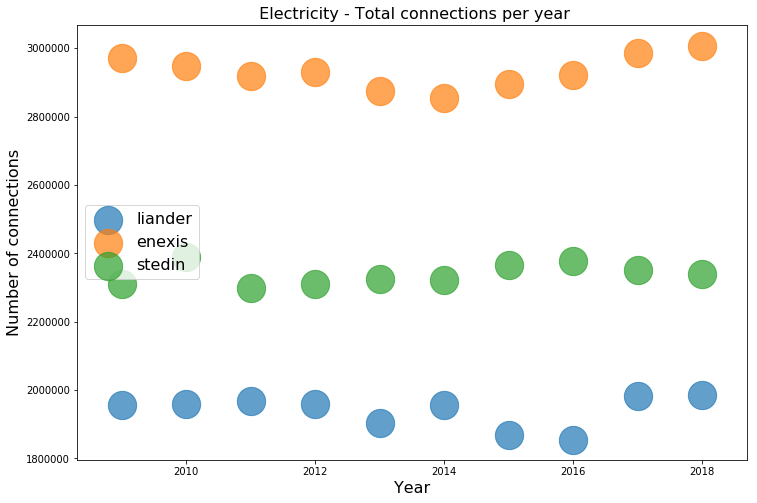

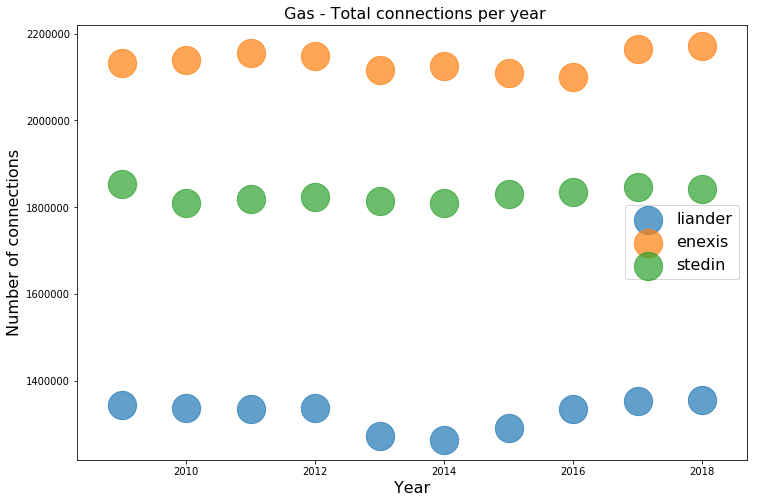

In [56]:
# First I explore network adminstrators total number connections per year for both Electricty and Gas
y=[]
 
# ELECTRICITY

plt.figure(figsize=(12, 8))
for df,color in zip(dfs_elec,['tab:blue', 'tab:orange', 'tab:green']):
       # filter by column related to number of connections
        y= df.filter(regex='^num_connection', axis=1).sum()
        plt.scatter(year, y, c= color, alpha=0.7, s=800)

plt.xlabel("Year", fontsize = 16)
plt.ylabel("Number of connections",fontsize = 16)
plt.title(" Electricity - Total connections per year",fontsize = 16)
plt.legend(utility_net_admin,fontsize = 16)


# GAS

plt.figure(figsize=(12, 8))
for df,color in zip(dfs_gas,['tab:blue', 'tab:orange', 'tab:green']):
        # filter by column related to number of connections
        y= df.filter(regex='^num_connection', axis=1).sum()
        plt.scatter(year, y, c= color, alpha=0.7, s=800)

plt.xlabel("Year", fontsize = 16)
plt.ylabel("Number of connections",fontsize = 16)
plt.title(" Gas - Total connections per year",fontsize = 16)
plt.legend(utility_net_admin,fontsize = 16,loc='best');



It is clear from the plots that Enexis has the most total number of connections for both Electricty and Gas, followed by Stedin and last is Liander

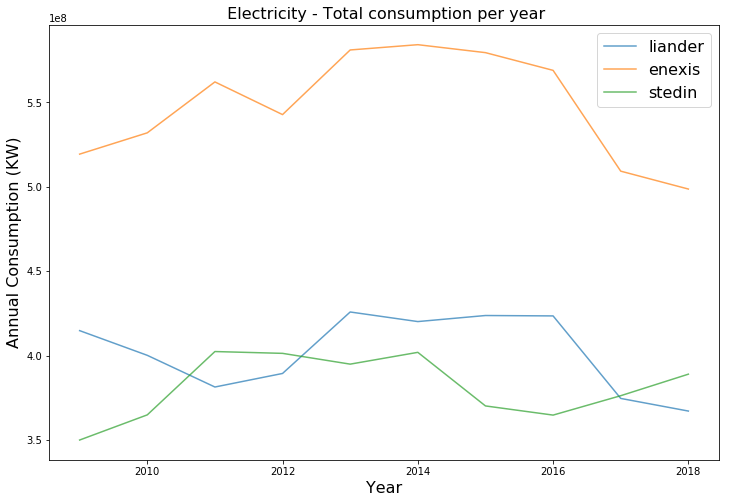

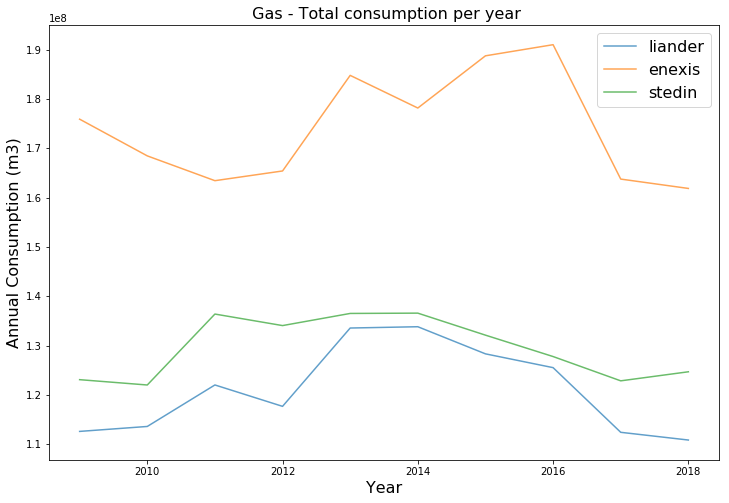

In [57]:
# I will now check if the annual consumption has the same trend as the total connections per year as seen above

y=[]

# ELECTRICITY
plt.figure(figsize=(12, 8))
    
for df,color in zip(dfs_elec,['tab:blue', 'tab:orange', 'tab:green']):
        # filter by column related to annual consumption
        y= df.filter(regex='^annual_consume_2', axis=1).sum()    
        plt.plot(year, y, c= color, alpha=0.7)

plt.xlabel("Year", fontsize = 16)
plt.ylabel('Annual Consumption (KW)',fontsize = 16)
plt.title(" Electricity - Total consumption per year",fontsize = 16)
plt.legend(utility_net_admin,fontsize = 16);


# GAS
plt.figure(figsize=(12, 8))

for df,color in zip(dfs_gas,['tab:blue', 'tab:orange', 'tab:green']):
        # filter by column related to annual consumption
        y= df.filter(regex='annual_consume_2', axis=1).sum()
        plt.plot(year, y, c= color, alpha=0.7)

plt.xlabel("Year", fontsize = 16)
plt.ylabel("Annual Consumption (m3)",fontsize = 16)
plt.title(" Gas - Total consumption per year",fontsize = 16)
plt.legend(utility_net_admin,fontsize = 16,loc='best');


The total annual consumption per year for both Electrical and Gas , indicate that Enexis still the major player but the Liander and Stedin have very similar annual consumtpion eventhough Stedin have clearly more total connections as seen previously

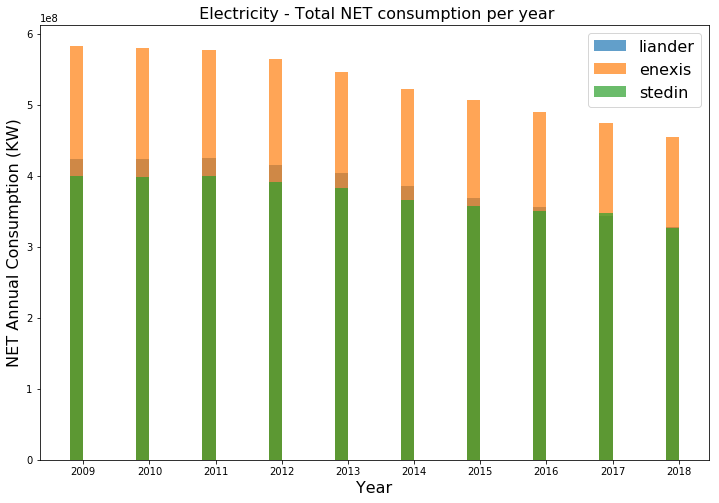

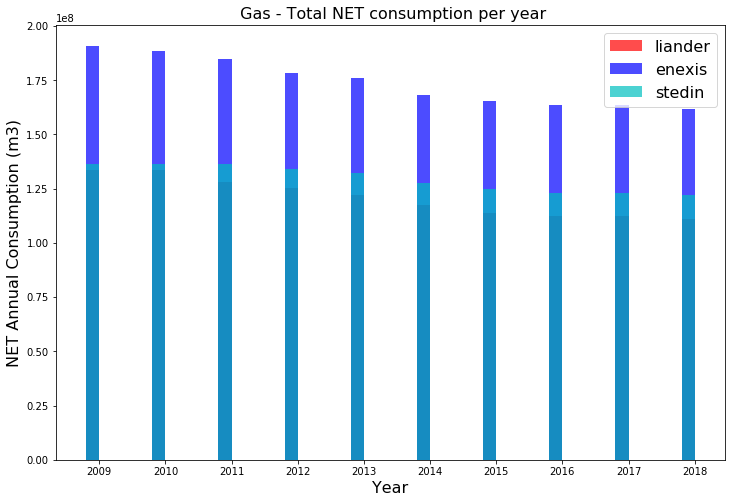

In [58]:
# I will  look at net energy consumption and calculate produced energy.

# 1) Net energy consumption is equal to: Annual Consume * delivery_per
years=['2009','2010','2011','2012','2013','2014','2015','2016','2017','2018']
 
    
# ELECTRICITY
plt.figure(figsize=(12, 8))
for df,color in zip(dfs_elec,['tab:blue', 'tab:orange', 'tab:green']):
  
    y=[]
    for yr in years:
    
        col1 = 'delivery_perc_' + yr
        
        col2 = 'annual_consume_' + yr
    
        df['net_energy_consumption_'+ yr] = (df[col1]/100) * df[col2]
        
        l = df['net_energy_consumption_'+ yr].sum()
        
        y.append(l)     
     
    plt.bar(years, y, alpha=0.7,align='edge',width= -0.2)

    plt.xlabel("Year", fontsize = 16)
    plt.ylabel('NET Annual Consumption (KW)',fontsize = 16)
    plt.title(" Electricity - Total NET consumption per year",fontsize = 16)
    plt.legend(utility_net_admin,fontsize = 16);
  

 #GAS
plt.figure(figsize=(12, 8))

for df,cl in zip(dfs_gas,['r', 'b', 'c']):
    
    y=[]
    for yr in years:
    
        col1 = 'delivery_perc_' + yr
        
        col2 = 'annual_consume_' + yr
    
        df['net_energy_consumption_'+ yr] = (df[col1]/100) * df[col2]
        
        l = df['net_energy_consumption_'+ yr].sum()
       
        y.append(l)     
     
    plt.bar(years, y, alpha=0.7,align='edge',width= -0.2,color=cl)

    plt.xlabel("Year", fontsize = 16)
    plt.ylabel('NET Annual Consumption (m3)',fontsize = 16)
    plt.title(" Gas - Total NET consumption per year",fontsize = 16)
    plt.legend(utility_net_admin,fontsize = 16);
    

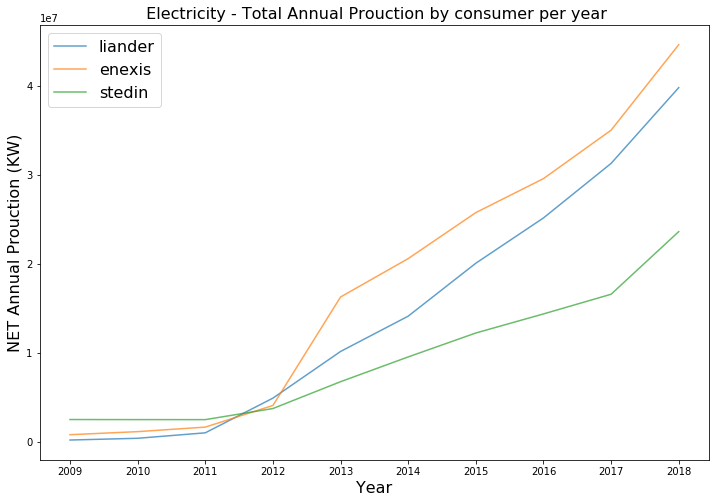

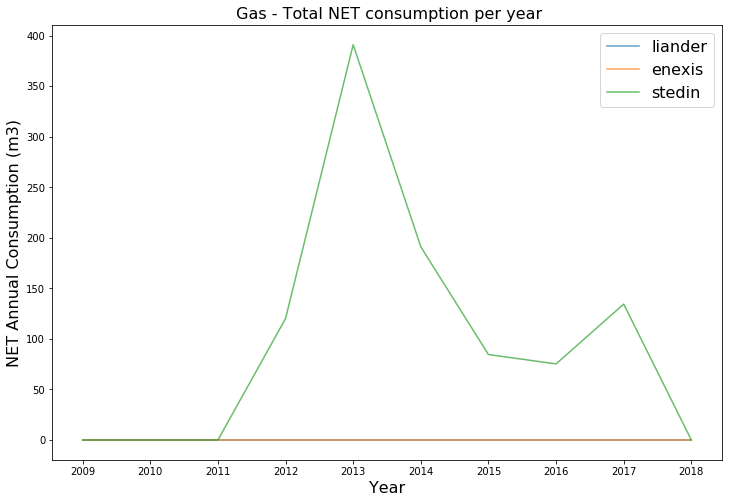

In [59]:
#2 Produced energey by consumers: is equal to Annual consume - Net energy consumption

years=['2009','2010','2011','2012','2013','2014','2015','2016','2017','2018']

# ELECTRICITY

plt.figure(figsize=(12, 8))

for df,color in zip(dfs_elec,['tab:blue', 'tab:orange', 'tab:green']):
    
    y=[]
    for yr in years:
    
        col1 = 'annual_consume_' + yr 
        col2 = 'net_energy_consumption_' + yr
        
        df['energy_produced_'+ yr] = df[col1] - df[col2]
        
        l = df['energy_produced_'+ yr].sum()
        y.append(l)     
     
    plt.plot(years, y, alpha=0.7)

    plt.xlabel("Year", fontsize = 16)
    plt.ylabel('NET Annual Prouction (KW)',fontsize = 16)
    plt.title(" Electricity - Total Annual Prouction by consumer per year",fontsize = 16)
    plt.legend(utility_net_admin,fontsize = 16);
 

 # GAS

plt.figure(figsize=(12, 8))

for df,cl in zip(dfs_gas,['r', 'b', 'c']):
    
    y=[]
    for yr in years:
    
        col1 = 'annual_consume_' + yr
        col2 = 'net_energy_consumption_' + yr
    
        df['energy_produced_'+ yr] = df[col1] - df[col2]
        
        l = df['energy_produced_'+ yr].sum()
        y.append(l)     
     
    plt.plot(years, y, alpha=0.7)

    plt.xlabel("Year", fontsize = 16)
    plt.ylabel('NET Annual Consumption (m3)',fontsize = 16)
    plt.title(" Gas - Total NET consumption per year",fontsize = 16)
    plt.legend(utility_net_admin,fontsize = 16);




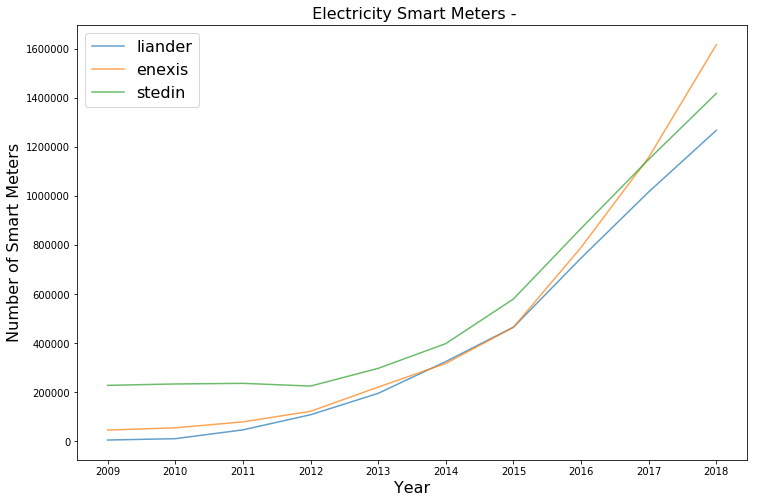

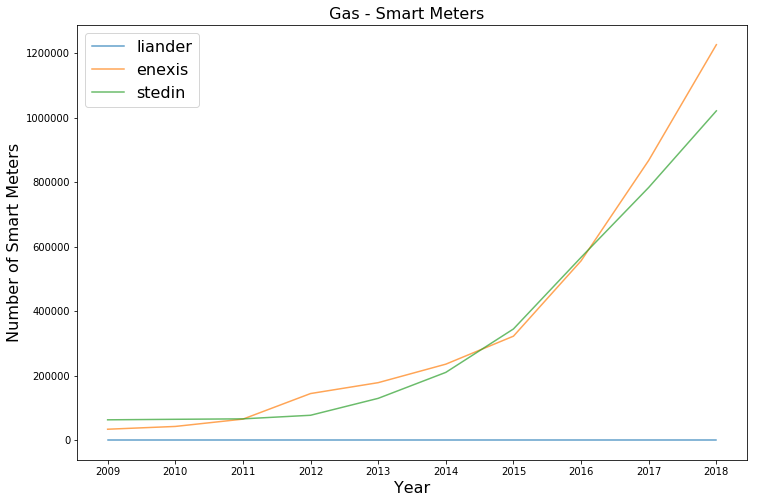

In [60]:
# SMART METERS
#1) Moving on to calculate and investigate smart meters trend

# Number of smart meters = Number of connections * Smart_meter percentage

years=['2009','2010','2011','2012','2013','2014','2015','2016','2017','2018']
 
# Electricty

plt.figure(figsize=(12, 8))
for df,color in zip(dfs_elec,['tab:blue', 'tab:orange', 'tab:green']):
  
    y=[]
    for yr in years:
    
        col1 = 'num_connections_' + yr
        col2 = 'smartmeter_perc_' + yr

        df['smart_meters_'+ yr] = df[col1] * (df[col2]/100)
        
        l = df['smart_meters_'+ yr].sum()
        y.append(l)     
     
    plt.plot(years, y, alpha=0.7)

    plt.xlabel("Year", fontsize = 16)
    plt.ylabel('Number of Smart Meters',fontsize = 16)
    plt.title(" Electricity Smart Meters -",fontsize = 16)
    plt.legend(utility_net_admin,fontsize = 16);

# Gas
plt.figure(figsize=(12, 8))
for df,cl in zip(dfs_gas,['r', 'b', 'c']):
    
    y=[]
    for yr in years:
        
        col1 = 'num_connections_' + yr
        col2 = 'smartmeter_perc_' + yr

        df['smart_meters_'+ yr] = df[col1] * (df[col2]/100)
        
        l = df['smart_meters_'+ yr].sum()
        y.append(l)      
     
    plt.plot(years, y, alpha=0.7)

    plt.xlabel("Year", fontsize = 16)
    plt.ylabel('Number of Smart Meters',fontsize = 16)
    plt.title(" Gas - Smart Meters   ",fontsize = 16)
    plt.legend(utility_net_admin,fontsize = 16);

###  II- City Level

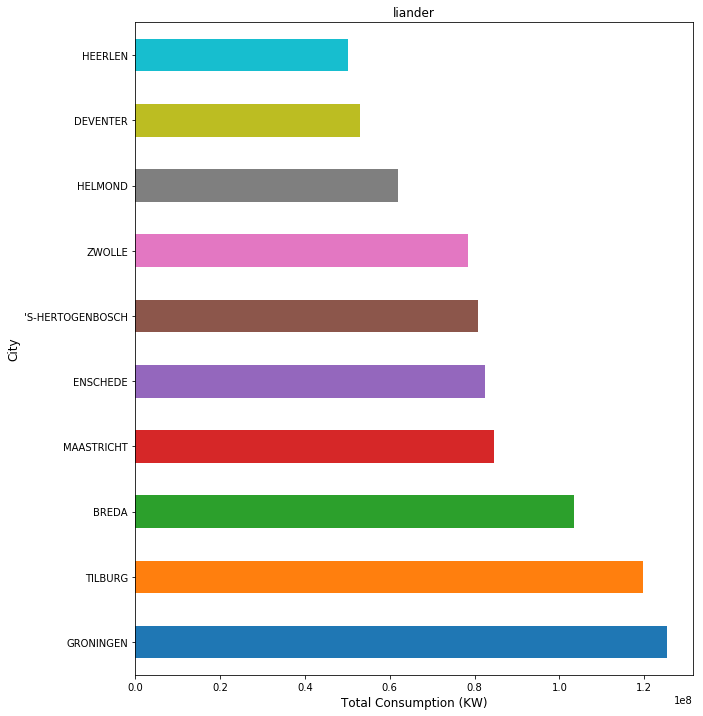

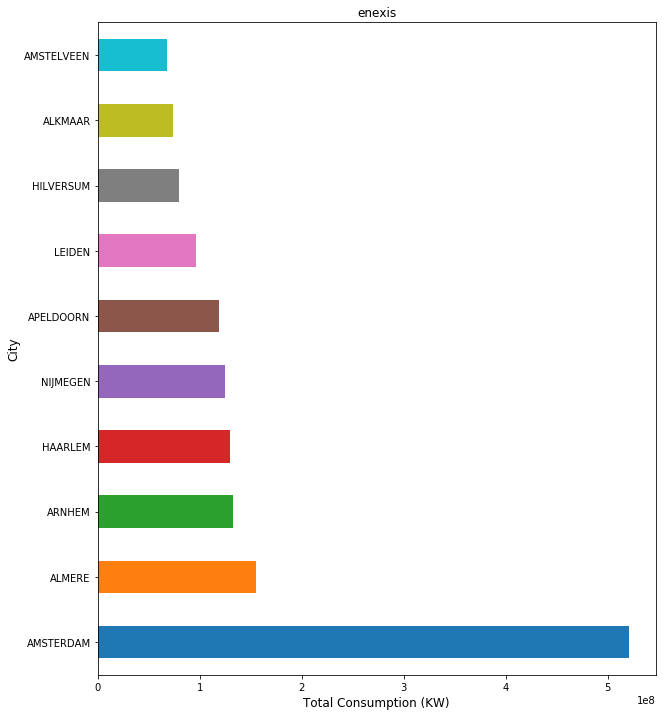

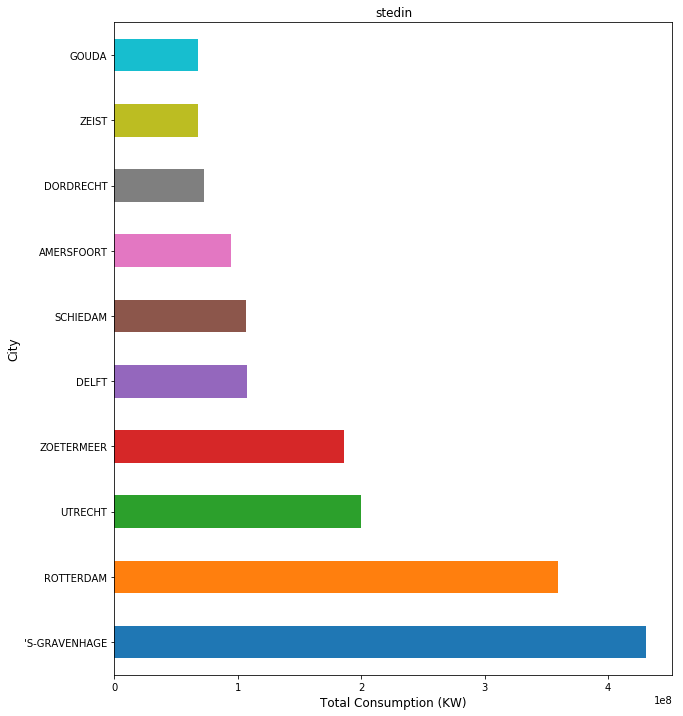

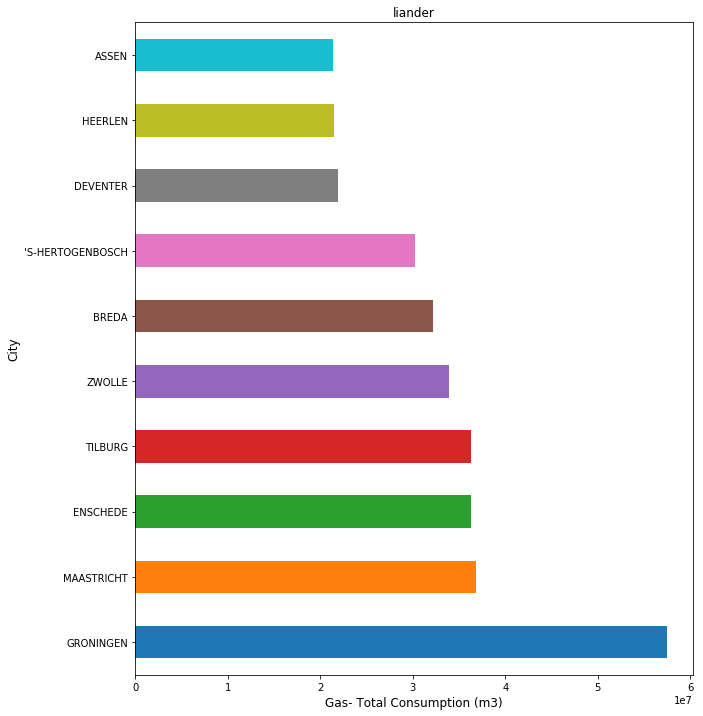

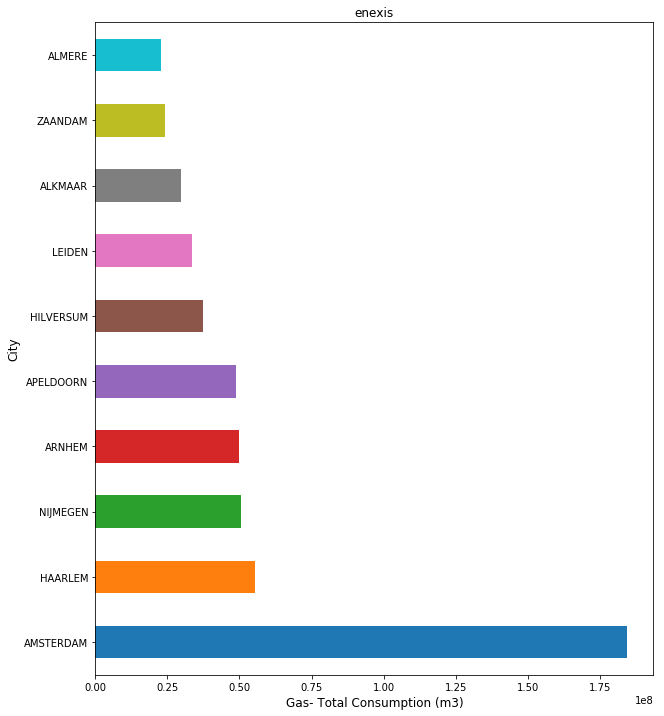

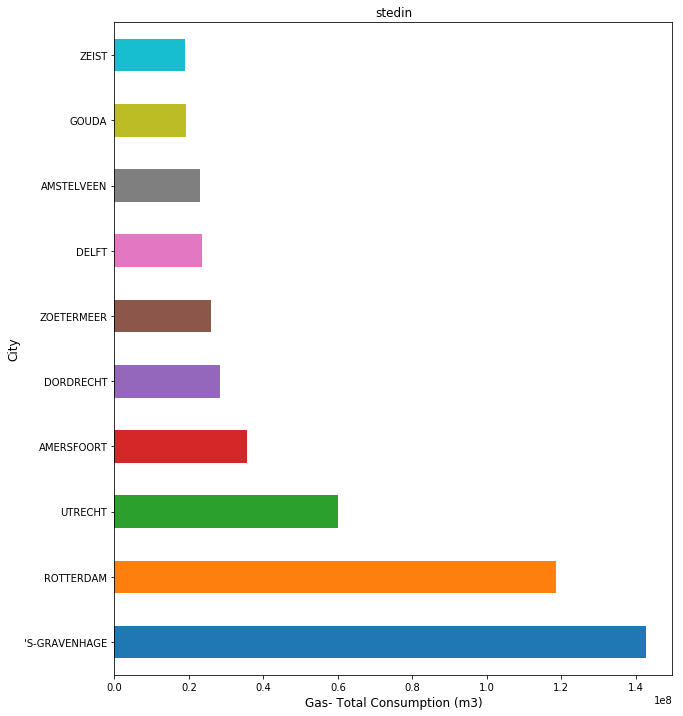

In [61]:
# I move down to city level

# Top 10 most consuming cities
years=['2009','2010','2011','2012','2013','2014','2015','2016','2017','2018']

# Electricity

for df,net_name, i in zip(dfs_elec,utility_net_admin,[1,2,3]):

    plt.figure(figsize=(10, 12))
    #sum of annual consumption
    df['t_a_c'] = df.filter(regex='^annual_consume_2').sum(axis=1)
    # group by city and sort values
    df.groupby('city').t_a_c.sum().sort_values(ascending=False).head(10).plot(kind='barh')
    
    
    plt.xlabel("Total Consumption (KW)", fontsize = 12)
    plt.ylabel('City',fontsize = 12)
    plt.title(net_name,fontsize = 12)
    
# Gas
for df,net_name, i in zip(dfs_gas,utility_net_admin,[1,2,3]):

    plt.figure(figsize=(10, 12))
    #sum of annual consumption
    df['t_a_c'] = df.filter(regex='^annual_consume_2').sum(axis=1)
    # group by city and sort values
    df.groupby('city').t_a_c.sum().sort_values(ascending=False).head(10).plot(kind='barh')
   
    plt.xlabel("Gas- Total Consumption (m3)", fontsize = 12)
    plt.ylabel('City',fontsize = 12)
    plt.title(net_name,fontsize = 12)
    

Top cities of Total energy consumption for both Gas and Eletricty are:
For Liander network : Groningen
For Enexis  network : Amsterdam
For Stedin  network : S-gravenhage


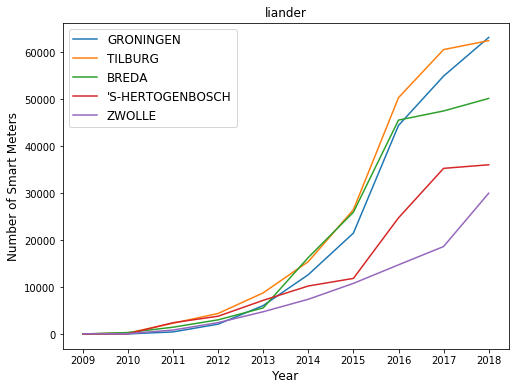

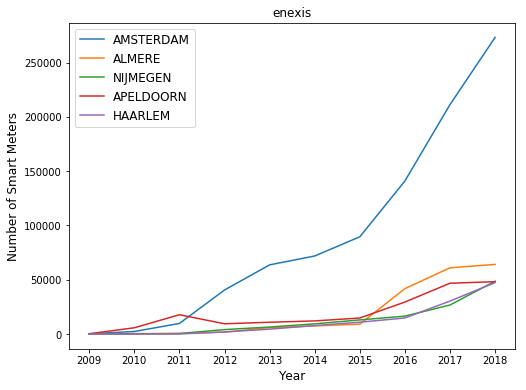

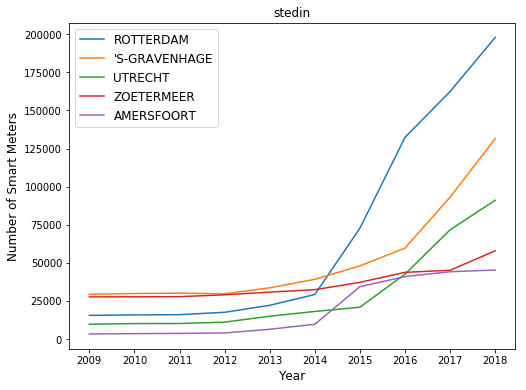

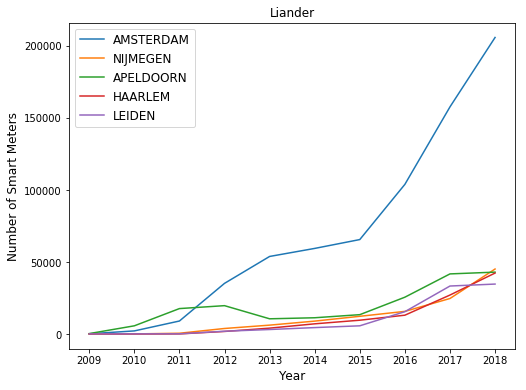

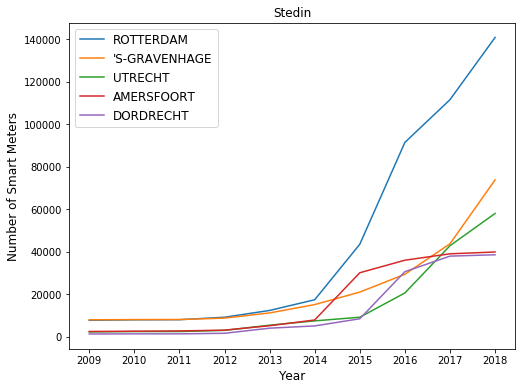

In [62]:
# I will investigate top 10 cities with most smart meters and their journey throughout the years

years=['2009','2010','2011','2012','2013','2014','2015','2016','2017','2018']

# ELECTRICITY
for df , nm in zip(dfs_elec,utility_net_admin):
    
   # group by city for the 5 largest smart_meters number for year 2018 observations
    dt_e = df.groupby(('city'),as_index=False).sum().nlargest(5, ['smart_meters_2018'])
    
    plt.figure(figsize=(8, 6))
    
    # loop through the 5 values
    for i in range(0,5):
    
        # filter by city and smart meters for the 10 years
        d_c_s = dt_e[['city','smart_meters_2009','smart_meters_2010','smart_meters_2011','smart_meters_2012','smart_meters_2013','smart_meters_2014','smart_meters_2015','smart_meters_2016','smart_meters_2017','smart_meters_2018']]
        # Extract city trends of smart meters
        d_trend_e = d_c_s.filter(regex='^smart_meters_2', axis=1).iloc[i]
        
        city_name =dt_e.city
        plt.plot(years,d_trend_e)
        plt.legend(city_name,fontsize = 12)
        plt.xlabel("Year", fontsize = 12)
        plt.ylabel('Number of Smart Meters',fontsize = 12)
        plt.title(nm,fontsize = 12)
        
# GAS
# exclude Liander as we seen previously this network adminstrator do not have any smart meters data
for df , nm  in zip([df_l_g,df_s_g],['Liander', 'Stedin']):
    
    # group by city for the 5 largest smart_meters number for year 2018 observations
    dt_g = df.groupby(('city'),as_index=False).sum().nlargest(5, ['smart_meters_2018'])
    
    plt.figure(figsize=(8, 6))
    
    # loop through the 5 values
    for i in range(0,5):
    
        # filter by city and smart meters for the 10 years
        d_c_g=dt_g[['city','smart_meters_2009','smart_meters_2010','smart_meters_2011','smart_meters_2012','smart_meters_2013','smart_meters_2014','smart_meters_2015','smart_meters_2016','smart_meters_2017','smart_meters_2018']]
        # Extract city trends of smart meters
        d_trend_g= d_c_g.filter(regex='^smart_meters_2', axis=1).iloc[i]
        city_name=dt_g.city
    
        plt.plot(years,d_trend_g)
        plt.legend(city_name,fontsize = 12)
        plt.title(nm,fontsize = 12)
        plt.xlabel("Year", fontsize = 12)
        plt.ylabel('Number of Smart Meters',fontsize = 12);
        

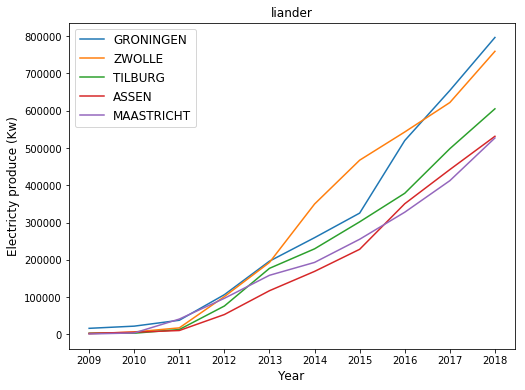

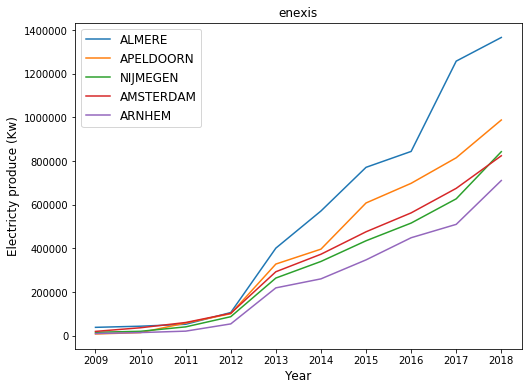

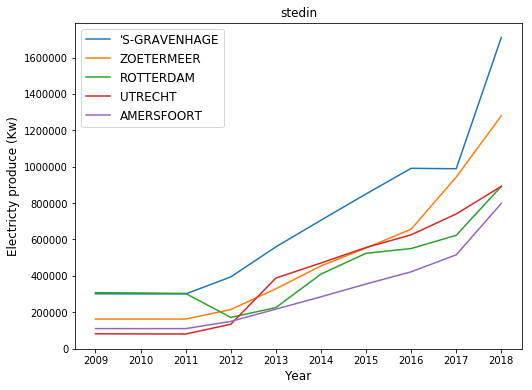

In [63]:
# Now I will investigatetop 10 cities with most self production and their journey throughout the years

# Only Electrity self production

years=['2009','2010','2011','2012','2013','2014','2015','2016','2017','2018']

for df , nm in zip(dfs_elec,utility_net_admin):
    
    # group by city for the 5 largest self prodcution number for year 2018 observations
    d_e_p = df.groupby(('city'),as_index=False).sum().nlargest(5, ['energy_produced_2018'])
    
    plt.figure(figsize=(8, 6))
    
    # Loop through the 5 cities
    for i in range(0,5):
        
         # filter by city and energy produced for the 10 years
        f=d_e_p[['city','energy_produced_2009','energy_produced_2010','energy_produced_2011','energy_produced_2012','energy_produced_2013','energy_produced_2014','energy_produced_2015','energy_produced_2016','energy_produced_2017','energy_produced_2018']]
        
        # Extract city trends of self energy produced
        y= f.filter(regex='^energy_produced_2', axis=1).iloc[i]
        city_names=d_e_p.city
    
        plt.plot(years,y)
        plt.xlabel("Year", fontsize = 12)
        plt.ylabel('Electricty produce (Kw)',fontsize = 12)
        plt.legend(city_names,fontsize = 12);
        plt.title(nm,fontsize = 12)
        

        

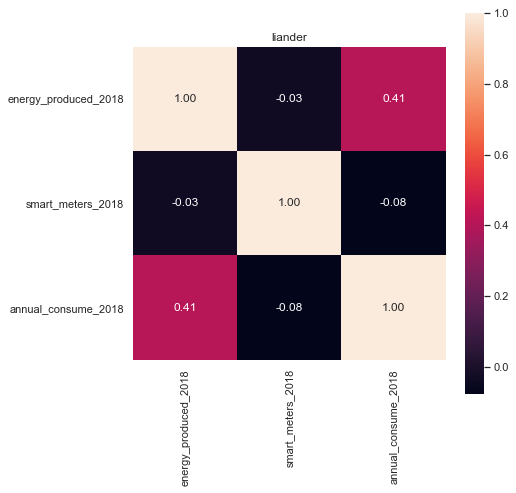

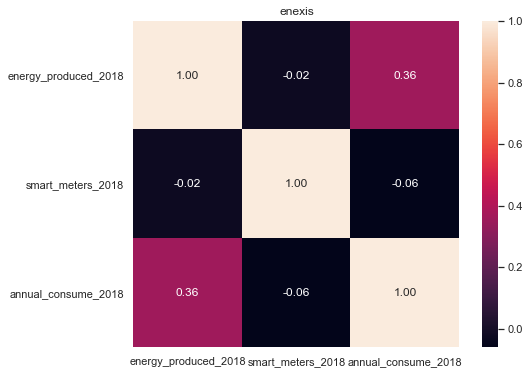

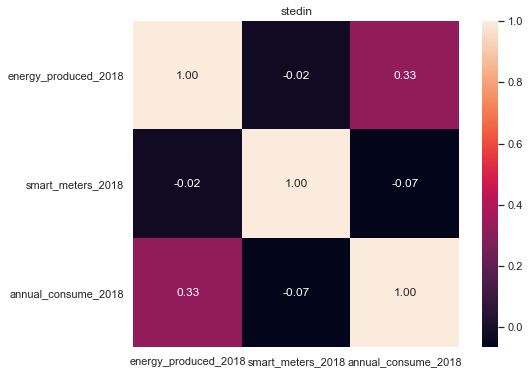

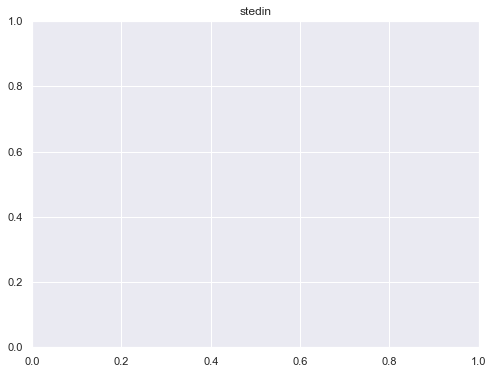

In [64]:
# Finally I will invesigate Correlation between energy consumed , eergy produced and smart meter for year 2018

for df , nm in zip(dfs_elec,utility_net_admin):
    
    #columns to find out correlation
    cols = ['energy_produced_2018', 'smart_meters_2018','annual_consume_2018']

    #Find out correlation between columns and plot
    corrs = np.corrcoef(df[cols].values.T)
    sns.set(font_scale=1)
    
    sns.set(rc={'figure.figsize':(7,7)})
    
    hm=sns.heatmap(corrs, cbar = True, annot=True, square = True, fmt = '.2f',
    yticklabels = cols, xticklabels = cols).set_title(nm)
    plt.figure(figsize=(8, 6))
    plt.yticks(rotation=0)
    plt.title(nm,fontsize = 12)

##  III- MODELING

In [65]:
# Create model to predict eletricty uasage per city

In [66]:
# My independent variables are: 1) Number_connections , 2) Number_smart_meters, 3) net_manager, 
                                #4) percent_active_connection, 5) delivery_percent

years=['2009','2010','2011','2012','2013','2014','2015','2016','2017','2018']
cols = ['annual_consume_','num_connections_', 'smart_meters_','perc_of_active_connections_','delivery_perc_']
o=['city']


pieces=[]


for yr in years: 
    for col in cols:
        
            col_yr = col + yr
            o.append(col_yr)
            
            # Electricity Enexis
            dg_e_e=df_e_e.groupby(('city'),as_index=False).mean()[o]
            dg_e_e['net_manager']='Enexis'
         
            # Electricity Liander
            dg_l_e=df_l_e.groupby(('city'),as_index=False).mean()[o]
            dg_l_e['net_manager']='Liander'
            
            # Electricity Stedin
            dg_s_e=df_s_e.groupby(('city'),as_index=False).mean()[o]
            dg_s_e['net_manager']='Stedin'
           

    pieces=[dg_e_e,dg_l_e,dg_s_e]

# Final data frame of all 3 network adminstrators
df_f=pd.concat(pieces).reset_index(drop=True)
print(df)

         net_manager   purchase_area                    street zipcode_from  \
0      8716874000009  Stedin Utrecht             Rembrandtlaan       1231AC   
1      8716874000009  Stedin Utrecht             Rembrandtlaan       1231AD   
2      8716874000009  Stedin Utrecht             Jan Steenlaan       1231AE   
3      8716874000009  Stedin Utrecht       Pieter de Hooghlaan       1231AG   
4      8716874000009  Stedin Utrecht         Paulus Potterlaan       1231AH   
5      8716874000009  Stedin Utrecht            Van Mierislaan       1231AJ   
6      8716874000009  Stedin Utrecht            Van Ostadelaan       1231AK   
7      8716874000009  Stedin Utrecht         Van der Helstlaan       1231AL   
8      8716874000009  Stedin Utrecht         Van der Helstlaan       1231AM   
9      8716874000009  Stedin Utrecht               Vermeerlaan       1231AN   
10     8716874000009  Stedin Utrecht               Vermeerlaan       1231AP   
11     8716874000009  Stedin Utrecht              Ru

### Split for Train and Test


In [67]:
features = []

# target prediction
target = "annual_consume_2018"
years = ['2009','2010','2011','2012','2013','2014','2015','2016','2017','2018']

# feature columns 
features = list(df_f.columns.values)

features = [e for e in features if e not in ('city','net_manager','annual_consume_2018')]

# split data into X and y
Y = df_f[target]
#print(X)
X = df_f[features]
#print(Y)

# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

## Linear Regression

In [68]:
# fit model no training data for Linear Regrerssion

model = LinearRegression()
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]


print(model.intercept_)
print(model.coef_)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

263.3797713276135
[-1.78567509e-01  2.38832157e+01 -3.10086143e+01  8.80981056e+00
 -1.27511632e+01  5.02838776e-02  3.90661909e+01 -6.86516360e+01
 -3.38776789e-01  6.62896418e+01 -1.20504360e-01 -8.99565324e+01
  9.14139197e+01  3.29711576e+01 -3.34187035e+01  2.57431162e-01
  2.80858068e+01 -3.10002573e+01 -1.10529143e+01 -4.14390229e+01
  4.58840188e-03 -1.05225732e+02 -5.91190499e+00 -4.29773498e+01
  2.01439838e+01  1.33159198e-02  6.36196384e+01  8.95973727e+00
  2.24548810e+00 -3.03732814e+00 -8.26262750e-02  1.18674510e+01
  6.75456703e-01  2.22164910e+01 -3.23803577e+01  5.52816129e-01
  1.43767155e+01 -1.15073493e+00 -6.83007092e+00  2.53206734e+01
  4.84667576e-01 -1.76468862e+02 -1.77404302e+00 -4.52038506e+01
 -2.76714135e-01  1.90463668e+02  1.50181569e+00  4.31267682e+01
  6.07233784e+00]
Mean Absolute Error: 197.32523975387704
Mean Squared Error: 168267.50012869274
Root Mean Squared Error: 410.2042175900837


In [69]:
df_f['annual_consume_2018'].describe()

count     2282.000000
mean      5314.749781
std       2414.406613
min       1282.000000
25%       3949.016340
50%       4633.057059
75%       5848.175398
max      31623.410000
Name: annual_consume_2018, dtype: float64

Lookig at the anual_conusme_2018 range, it is clear that the model is fitting the data well where RMSE is 410 compared to mean consumption for the year 2018 of 5,315.
It is also to be noted that addtional Features such population, time of year, average family size can better 

## Random Forest

In [70]:
# fit model no training data for Random Forest
forest_reg = RandomForestRegressor()
forest_reg.fit(X_train, y_train)

# make predictions for test data
y_pred = forest_reg.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions

print(model.intercept_)
print(model.coef_)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

/Users/Walz/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


263.3797713276135
[-1.78567509e-01  2.38832157e+01 -3.10086143e+01  8.80981056e+00
 -1.27511632e+01  5.02838776e-02  3.90661909e+01 -6.86516360e+01
 -3.38776789e-01  6.62896418e+01 -1.20504360e-01 -8.99565324e+01
  9.14139197e+01  3.29711576e+01 -3.34187035e+01  2.57431162e-01
  2.80858068e+01 -3.10002573e+01 -1.10529143e+01 -4.14390229e+01
  4.58840188e-03 -1.05225732e+02 -5.91190499e+00 -4.29773498e+01
  2.01439838e+01  1.33159198e-02  6.36196384e+01  8.95973727e+00
  2.24548810e+00 -3.03732814e+00 -8.26262750e-02  1.18674510e+01
  6.75456703e-01  2.22164910e+01 -3.23803577e+01  5.52816129e-01
  1.43767155e+01 -1.15073493e+00 -6.83007092e+00  2.53206734e+01
  4.84667576e-01 -1.76468862e+02 -1.77404302e+00 -4.52038506e+01
 -2.76714135e-01  1.90463668e+02  1.50181569e+00  4.31267682e+01
  6.07233784e+00]
Mean Absolute Error: 175.92085845216957
Mean Squared Error: 167839.5645416722
Root Mean Squared Error: 409.6822726719722


RandomForest is also a better predictore modet that Linear Regression with RMSE of 400 rnage comapred to 410 for LR